<a href="https://colab.research.google.com/github/kumuds4/BCH/blob/master/Making_the_Most_of_your_Colab_Subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making the Most of your Colab Subscription



## Faster GPUs

Users who have purchased one of Colab's paid plans have access to faster GPUs and more memory. You can upgrade your notebook's GPU settings in `Runtime > Change runtime type` in the menu to select from several accelerator options, subject to availability.

The free of charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to `Runtime > Change runtime type` in the menu to enable a GPU accelerator, and then re-execute the code cell.


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 27 02:58:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             47W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In order to use a GPU with your notebook, select the `Runtime > Change runtime type` menu, and then set the hardware accelerator to the desired option.

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available. More powerful GPUs are always offered with high-memory VMs.



You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.


In [2]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). Colab Pro and Pro+ users have access to longer runtimes than those who use Colab free of charge.

## Background execution

Colab Pro+ users have access to background execution, where notebooks will continue executing even after you've closed a browser tab. This is always enabled in Pro+ runtimes as long as you have compute units available.



## Relaxing resource limits in Colab Pro

Your resources are not unlimited in Colab. To make the most of Colab, avoid using resources when you don't need them. For example, only use a GPU when required and close Colab tabs when finished.



If you encounter limitations, you can relax those limitations by purchasing more compute units via Pay As You Go. Anyone can purchase compute units via [Pay As You Go](https://colab.research.google.com/signup); no subscription is required.

## Send us feedback!

If you have any feedback for us, please let us know. The best way to send feedback is by using the Help > 'Send feedback...' menu. If you encounter usage limits in Colab Pro consider subscribing to Pro+.

If you encounter errors or other issues with billing (payments) for Colab Pro, Pro+, or Pay As You Go, please email [colab-billing@google.com](mailto:colab-billing@google.com).

## More Resources

### Working with Notebooks in Colab
- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<a name="working-with-data"></a>
### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)


<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TPUs in Colab](/notebooks/tpu.ipynb)

<a name="machine-learning-examples"></a>

## Machine Learning Examples

To see end-to-end examples of the interactive machine learning analyses that Colab makes possible, check out these tutorials using models from [TensorFlow Hub](https://tfhub.dev).

A few featured examples:

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.


In [ ]:
#latest plot functions
# Updates code script
# Comprehensive Polar Code Simulation Framework
# Clean up and install necessary libraries in one go
# This helps avoid potential conflicts from multiple installations
# Explicitly uninstall pandas and install a compatible version first
# Google Colab requires pandas==2.2.2 as of the last error message.
# Comprehensive Uninstall
#!pip list | grep -E "numpy|pandas|scipy|torch"
#!pip install numpy==1.24.4 pandas==1.5.3
#!pip install numpy==1.24.4 --no-cache-dir
#!pip install pandas==1.5.3 --no-cache-dir
!pip uninstall -y torch torchvision torchaudio fastai numba tensorflow tensorflow-decision-forests tensorflow-text tf-keras numpy pandas scikit-learn scipy cuml-cu12 cudf-cu12 dask-cuda distributed-ucxx-cu12 ml-dtypes tensorboard dask-cudf-cu12 raft-dask-cu12 sklearn-pandas

# Install core libraries with --upgrade to force versions
!pip install numpy==1.26.4 --upgrade --no-cache-dir
#!pip install scipy==1.14.0 --upgrade --no-cache-dir
!pip install pandas==2.2.2 --upgrade --no-cache-dir
#!pip install scikit-learn==1.4.1.post1 --upgrade --no-cache-dir
#!pip install sklearn-pandas==2.2.8 --upgrade --no-cache-dir
# Rest of your installations (commented out for this test)
# !pip install scipy==1.14.0 --no-cache-dir
# !pip install scikit-learn==1.4.1.post1 --no-cache-dir
# !pip install sklearn-pandas==2.2.8 --no-cache-dir # Explicitly install sklearn-pandas after pandas
# !pip install torch==2.6.0 torchvision==0.21.0+cu124 torchaudio==2.6.0+cu124 --extra-index-url https://download.pytorch.org/whl/cu124 --no-cache-dir
# !pip install fastai==2.7.19 --no-cache-dir
# !pip install matplotlib --no-cache-dir
# !pip install tensorflow==2.18.0 tensorflow-decision-forests tensorflow-text tf-keras --no-cache-dir
# !pip install numba==0.60.0 --no-cache-dir
# Install other libraries with --upgrade
#!pip install torch==2.6.0 torchvision==0.21.0+cu124 torchaudio==2.6.0+cu124 --extra-index-url https://download.pytorch.org/whl/cu124 --upgrade --no-cache-dir
#!pip install fastai==2.7.19 --upgrade --no-cache-dir
#!pip install matplotlib --upgrade --no-cache-dir
#!pip install tensorflow==2.18.0 tensorflow-decision-forests tensorflow-text tf-keras --upgrade --no-cache-dir
#!pip install numba==0.60.0 --upgrade --no-cache-dir
# Install other libraries, including Torch and its related packages
!pip install scipy==1.14.0 --no-cache-dir
!pip install scikit-learn==1.4.1.post1 --no-cache-dir
!pip install sklearn-pandas==2.2.8 --no-cache-dir # Explicitly install sklearn-pandas after pandas
!pip install torch==2.6.0 torchvision==0.21.0+cu124 torchaudio==2.6.0+cu124 --extra-index-url https://download.pytorch.org/whl/cu124 --no-cache-dir
!pip install fastai==2.7.19 --no-cache-dir
!pip install matplotlib --no-cache-dir
!pip install tensorflow==2.18.0 tensorflow-decision-forests tensorflow-text tf-keras --no-cache-dir
!pip install numba==0.60.0 --no-cache-dir
# Install RAPIDS libraries if you need them, making sure to match versions and Numba/CUDA compatibility
# !pip install cuml-cu12==25.2.1 cudf-cu12==25.2.1 dask-cuda==25.2.0 distributed-ucxx-cu12==0.42.0 dask-cudf-cu12==25.2.2 raft-dask-cu12==25.2.0 --extra-index-url=https://pypi.nvidia.com --no-cache-dir
# Install RAPIDS libraries if you need them, making sure to match versions and Numba/CUDA compatibility
# !pip install cuml-cu12==25.2.1 cudf-cu12==25.2.1 dask-cuda==25.2.0 distributed-ucxx-cu12==0.42.0 dask-cudf-cu12==25.2.2 raft-dask-cu12==25.2.0 --extra-index-url=https://pypi.nvidia.com --upgrade --no-cache-dir
import logging
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scipy.special as sps # Added for theoretical performance
import traceback # Added for error tracing
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
# Install RAPIDS libraries if you need them, making sure to match versions and Numba/CUDA compatibility
# !pip install cuml-cu12==25.2.1 cudf-cu12==25.2.1 dask-cuda==25.2.0 distributed-ucxx-cu12==0.42.0 dask-cudf-cu12==25.2.2 raft-dask-cu12==25.2.0 --extra-index-url=https://pypi.nvidia.com --no-cache-dir
# Install RAPIDS libraries if you need them, making sure to match versions and Numba/CUDA compatibility
# !pip install cuml-cu12==25.2.1 cudf-cu12==25.2.1 dask-cuda==25.2.0 distributed-ucxx-cu12==0.42.0 dask-cudf-cu12==25.2.2 raft-dask-cu12==25.2.0 --extra-index-url=https://pypi.nvidia.com --no-cache-dir
# You may need to install RAPIDS libraries separately if you are using them:
# !pip install cuml-cu12==25.2.1 cudf-cu12==25.2.1 dask-cuda==25.2.0 distributed-ucxx-cu12==0.42.0
# Now install/upgrade other essential libraries to potentially compatible versions
#!pip install -q --upgrade numpy matplotlib scikit-learn torch
#!pip install -q --upgrade pandas numpy matplotlib scikit-learn torch


# Fix: Corrected format string for datefmt
# Fix: Corrected format string for datefmt
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s]: %(message)s', datefmt='%Y-%m-%d %H:%M:%S')



# Device Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using Device: {DEVICE}")

#part two

class PolarCodeGenerator:
    def __init__(self, N, K, crc_type='CRC-7'):
        self.N = N
        self.K = K
        self.crc_type = crc_type
        self.crc_polynomials = {
            'CRC-7': {'polynomial': [1, 1, 1, 0, 0, 1, 1], 'length': 7}
        }

    def generate_info_bits(self):
        return np.random.randint(2, size=self.K)

    def compute_crc(self, bits):
        poly_info = self.crc_polynomials.get(self.crc_type)
        if not poly_info:
            raise ValueError(f"Unsupported CRC type: {self.crc_type}")

        polynomial = poly_info['polynomial']
        crc_length = poly_info['length']
        message = bits.tolist() + [0] * crc_length
        for i in range(len(message) - crc_length):
            if message[i] == 1:
                for j in range(crc_length + 1):
                    message[i + j] ^= polynomial[j] if j < len(polynomial) else 0

        return np.array(message[-crc_length:], dtype=int)

    def polar_encode(self, info_bits):
        crc_bits = self.compute_crc(info_bits)
        extended_info_bits = np.concatenate([info_bits, crc_bits])
        codeword = np.zeros(self.N, dtype=int)
        codeword[:len(extended_info_bits)] = extended_info_bits
        return codeword

    def verify_codeword(self, codeword):
        poly_info = self.crc_polynomials[self.crc_type]
        crc_length = poly_info['length']
        info_bits = codeword[:-crc_length]
        received_crc = codeword[-crc_length:]
        computed_crc = self.compute_crc(info_bits)
        return np.array_equal(received_crc, computed_crc)

class EnhancedChannelSimulator:
    def __init__(self, channel_type='AWGN'):
        self.channel_type = channel_type
        logging.info(f"Initializing {channel_type} Channel Simulator")

    def simulate(self, encoded_signal, snr_db):
        try:
            encoded_signal = np.array(encoded_signal, dtype=float)
            bpsk_signal = 1 - 2 * encoded_signal
            snr_linear = 10 ** (snr_db / 10)
            signal_power = np.mean(bpsk_signal**2)
            noise_power = signal_power / snr_linear
            noise_std = np.sqrt(noise_power / 2.0)

            if self.channel_type == 'AWGN':
                noise = np.random.normal(0, noise_std, bpsk_signal.shape)
                received_signal = bpsk_signal + noise
            elif self.channel_type == 'Rayleigh':
                fading = np.random.rayleigh(scale=1.0, size=bpsk_signal.shape)
                noise = np.random.normal(0, noise_std, bpsk_signal.shape)
                received_signal = fading * bpsk_signal + noise
            else:
                raise ValueError(f"Unsupported channel type: {self.channel_type}")

            # Return the raw received signal instead of hard decisions for RNN input
            return received_signal
        except Exception as e:
            logging.error(f"Channel simulation error: {e}")
            # Return the original signal if simulation fails
            return bpsk_signal

    def compute_theoretical_performance(self, block_length, snr_linear):
        try:
            if self.channel_type == 'AWGN':
                # Theoretical BER for BPSK in AWGN
                bep = 0.5 * sps.erfc(np.sqrt(snr_linear))
            elif self.channel_type == 'Rayleigh':
                 # Theoretical BER for BPSK in Rayleigh (assuming ideal channel estimation)
                 bep = 0.5 * (1 - np.sqrt(snr_linear / (1 + snr_linear)))
            else:
                raise ValueError(f"Unsupported channel type: {self.channel_type}")

            # Theoretical BLER is complex for Polar codes; using a simple bound might be misleading.
            # Using a very loose upper bound (Union Bound)
            bler = 1 - (1 - bep) ** block_length
            return bep, bler
        except Exception as e:
            logging.error(f"Theoretical performance computation error: {e}")
            return np.zeros_like(snr_linear), np.ones_like(snr_linear)


#part three

def prepare_polar_dataset(polar_code_gen, num_samples, snr_db=5, channel_type='AWGN'):
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_type)
    X, y = [], []

    for _ in range(num_samples):
        info_bits = polar_code_gen.generate_info_bits()
        encoded_signal = polar_code_gen.polar_encode(info_bits)
        # Simulate the channel and get the received signal (soft values)
        received_signal = channel_simulator.simulate(encoded_signal, snr_db)
        X.append(received_signal)
        y.append(info_bits) # Keep the original info bits as labels

    return np.array(X), np.array(y)

#part four

class EnhancedRNNDecoder(nn.Module):
    def __init__(self, input_size, output_size):
        super(EnhancedRNNDecoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_size), # Output size is number of info bits (K)
            nn.Sigmoid()
        )

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        if x.dim() > 2:
            x = x.view(x.size(0), -1) # Flatten if input is not already 2D
        return self.model(x)
###########################################################
#add latest version for DecodertRainer
class DecoderTrainer:
    def __init__(self, model, learning_rate=1e-3):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=5
            # Remove 'verbose'
        )
        self.train_losses = []
        self.val_losses = []
 # Add other methods as defined in your code


    def train(self, X, y, epochs=100, batch_size=32, validation_split=0.2):
        X_tensor = X.to(self.device)
        y_tensor = y.to(self.device)

        dataset = TensorDataset(X_tensor, y_tensor)
        train_size = int((1 - validation_split) * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        for epoch in range(epochs):
            self.model.train()
            train_loss = self._train_epoch(train_loader)
            self.train_losses.append(train_loss)

            self.model.eval()
            val_loss = self._validate(val_loader)
            self.val_losses.append(val_loss)

            self.scheduler.step(val_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        return self.train_losses, self.val_losses

    def _train_epoch(self, dataloader):
        total_loss = 0
        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(self.device)
            batch_y = batch_y.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(batch_X)
            loss = self.criterion(outputs, batch_y)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def _validate(self, dataloader):
        total_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in dataloader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                total_loss += loss.item()
        return total_loss / len(dataloader)

    def predict(self, X):
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        if X.dim() > 2:
            X = X.view(X.size(0), -1)
        X = X.to(self.device)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
        return (outputs > 0.5).cpu().numpy().astype(int)

# Add traditional decoder
class SCLDecoder:
    def __init__(self, N, K, list_size, crc_type='CRC-7'):
        self.N = N
        self.K = K
        self.list_size = list_size
        self.crc_type = crc_type

    def decode(self, received_signal):
        # Simplified pseudo-code for SCL decoding
        # Initialize list paths and metrics
        paths = [np.zeros(self.N, dtype=int)] * self.list_size
        path_metrics = [0] * self.list_size

        # Successive cancellation with list keeping
        for i in range(self.N):
            # Update each path with new bit decision
            for l in range(self.list_size):
                # Example decision logic (to be replaced with actual SCL logic)
                paths[l][i] = self.make_decision(received_signal[i], path_metrics[l])

                # Update path metric
                path_metrics[l] += self.calculate_metric(paths[l][i], received_signal[i])

            # Sort and prune paths based on metrics (keep best `list_size` paths)
            best_indices = np.argsort(path_metrics)[:self.list_size]
            paths = [paths[i] for i in best_indices]
            path_metrics = [path_metrics[i] for i in best_indices]

        # Extract and return the best path
        best_path = paths[np.argmin(path_metrics)]
        return best_path[:self.K]  # Return the first K bits

    def make_decision(self, received_signal, path_metric):
        # Placeholder logic for bit decision
        return 0 if received_signal < 0.5 else 1

    def calculate_metric(self, bit_decision, received_signal):
        # Example metric computation (Hamming distance, etc.)
        return np.abs(bit_decision - received_signal)
##########################################################################
#latest SCL decoder
def run_scl_decoder(polar_code_gen, SNRS, list_size, channel_type, num_trials):
    results = []
    for snr_db in SNRS:
        X, y = prepare_polar_dataset(channel_type, polar_code_gen, num_samples=num_trials, snr_db=snr_db)

        decoder = SCLDecoder(N=polar_code_gen.N, K=polar_code_gen.K, list_size=list_size)
        decoded_bits = np.array([decoder.decode(x) for x in X])

        ber = np.sum(np.abs(decoded_bits - y)) / (num_trials * polar_code_gen.K)
        bler = np.mean(np.any(decoded_bits != y, axis=1))

        results.append({'SNR': snr_db, 'BER': ber, 'BLER': bler})
        print(f"SCL Decoder - SNR: {snr_db:.1f} dB, List Size: {list_size}, BER: {ber:.4f}, BLER: {bler:.4f}") # Add this line

    return results
##########################################################################

# part five

# Modified performance comparison to evaluate multi-bit predictions
# This function will now evaluate the same RNN decoder but store results keyed by 'list_size' labels.
#def performance_comparison(rnn_trainer, polar_code_gen, snr_range, channel_name, list_sizes, num_trials):
    # Initialize performance results dictionary to store results for each list size label
 #   performance_results = {list_size: {'BER': [], 'BLER': []} for list_size in list_sizes}
  #  channel_simulator = EnhancedChannelSimulator(channel_type=channel_name)

   # for snr_db in snr_range:
        # Generate data for performance evaluation
    #    X, y = prepare_polar_dataset(polar_code_gen, num_samples=num_trials, snr_db=snr_db, channel_type=channel_name)

     #   predictions = rnn_trainer.predict(X) # predictions shape: [num_trials, K]
      #  actual_labels = y # actual_labels shape: [num_trials, K]

        # Calculate BER: Total number of bit errors / Total number of bits
       # ber = np.sum(np.abs(predictions - actual_labels)) / (num_trials * polar_code_gen.K)

        # Calculate BLER: Number of blocks with at least one bit error / Total number of blocks
        #block_errors = np.sum(np.any(predictions != actual_labels, axis=1))
        #bler = block_errors / num_trials

        # Store the calculated BER and BLER for EACH specified list size label.
        # Note: The values are the same because it's the same RNN performance being measured.
        #for list_size in list_sizes:
         #   performance_results[list_size]['BER'].append(ber)
          #  performance_results[list_size]['BLER'].append(bler)

    #return performance_results

# Modified plot function to use the updated performance results structure
def plot_comprehensive_analysis(train_losses, val_losses, performance_results, snr_range, channel_name):
    plt.figure(figsize=(12, 15)) # Increased figure size

    # Plot Training and Validation Loss
    plt.subplot(3, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{channel_name} Channel - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot BER (from performance_results)
    plt.subplot(3, 1, 2)
    # Iterate through the decoder types (which are now just the list size labels)
    for list_size, results in performance_results.items():
        # Use the list_size as the label
        plt.plot(snr_range, results['BER'], label=f'RNN Decoder (List size {list_size})')

    plt.title(f'{channel_name} Channel - BER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.yscale('log')
    # Adjust ylim for BER to show better detail at lower error rates if needed
    plt.ylim(1e-4, 1) # Example adjustment
    plt.legend()
    plt.grid(True, which="both", ls="--") # Add grid

    # Plot BLER (from performance_results)
    plt.subplot(3, 1, 3)
    # Iterate through the decoder types (which are now just the list size labels)
    for list_size, results in performance_results.items():
        # Use the list_size as the label
        plt.plot(snr_range, results['BLER'], label=f'RNN Decoder (List size {list_size})')

    plt.title(f'{channel_name} Channel - BLER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.yscale('log')
     # Adjust ylim for BLER to show better detail at lower error rates if needed
    plt.ylim(1e-4, 1) # Example adjustment
    plt.legend()
    plt.grid(True, which="both", ls="--") # Add grid


    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.show()
####################################################
# another trial to have all plots




##########################################################


#####################################################
# with two SNR separately teh comparison of SCL tradional and ML decoder
######################################################################

##############################################################
def plot_ber_bler(results, channel_type, decoder_type, snr_range):
    plt.figure(figsize=(12, 16))

    # Plot BER
    plt.subplot(2, 1, 1)
    for i, list_size in enumerate(LIST_SIZES):
        ber = [res['BER'] for res in results[channel_type][decoder_type][i]]
        plt.plot(snr_range, ber, label=f'{decoder_type} Decoder (List Size {list_size})')

    plt.title(f'{channel_type} Channel - {decoder_type} BER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.yscale('log')
    plt.ylim(10**0, 10**-4)
    plt.legend()
    plt.grid(True, which="both", ls="--")

    # Plot BLER
    plt.subplot(2, 1, 2)
    for i, list_size in enumerate(LIST_SIZES):
        bler = [res['BLER'] for res in results[channel_type][decoder_type][i]]
        plt.plot(snr_range, bler, label=f'{decoder_type} Decoder (List Size {list_size})')

    plt.title(f'{channel_type} Channel - {decoder_type} BLER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.yscale('log')
    plt.ylim(10**0, 10**-4)
    plt.legend()
    plt.grid(True, which="both", ls="--")

    plt.tight_layout()
    plt.show()

##############################################################
#again plot results
###################################################
#latest plot functions
LIST_SIZES = [1, 8, 16]
SNR_AWGN     = np.linspace(0, 5, 11)
SNR_RAYLEIGH = np.linspace(0, 10, 11)
####################################################################
# Latest
def compare_decoders(polar_code_gen):
    results = {}
    for channel in ['AWGN','Rayleigh']:
        snr_grid = SNR_AWGN if channel=='AWGN' else SNR_RAYLEIGH

        ml_dict = {}
        scl_dict = {}

        # ML-decoder part (already working)

        # SCL-decoder
        for L in LIST_SIZES:
            scl_list = run_scl_decoder(
                polar_code_gen, snr_grid, L, channel, NUM_TRIALS_PERF
            )
            ber_list  = [x['BER']  for x in scl_list]
            bler_list = [x['BLER'] for x in scl_list]
            scl_dict[L] = {'BER':ber_list, 'BLER':bler_list}
            print(f"Compare Decoders - Channel: {channel}, SCL Results for L={L}: {scl_dict[L]}") # Add this line

        results[channel] = {'ML': ml_dict, 'SCL': scl_dict}
    return results
####################################################################


def plot_channel(results, channel, decoder_key, snr_grid):
    plt.figure(figsize=(10,6))
    # BER
    plt.subplot(2,1,1)
    for L in LIST_SIZES:
        y = results[channel][decoder_key][L]['BER']
        plt.plot(snr_grid, y, label=f"{decoder_key} L={L}")
    plt.title(f"{channel} – {decoder_key} BER")
    plt.yscale('log'); plt.ylim(1,1e-4)
    plt.xlabel("SNR (dB)"); plt.ylabel("BER")
    plt.grid(True,which='both'); plt.legend()

    # BLER
    plt.subplot(2,1,2)
    for L in LIST_SIZES:
        y = results[channel][decoder_key][L]['BLER']
        plt.plot(snr_grid, y, label=f"{decoder_key} L={L}")
    plt.title(f"{channel} – {decoder_key} BLER")
    plt.yscale('log'); plt.ylim(1,1e-4)
    plt.xlabel("SNR (dB)"); plt.ylabel("BLER")
    plt.grid(True,which='both'); plt.legend()

    plt.tight_layout()
    plt.show()

###################################################
def performance_comparison(rnn_trainer, polar_code_gen, snr_range, channel_name, list_sizes, num_trials):
    performance_results = {list_size: {'BER': [], 'BLER': []} for list_size in list_sizes}
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_name)

    for list_size in list_sizes:
        for snr_db in snr_range:
            # Here, introduce any logic specific to list_size
            X, y = prepare_polar_dataset(polar_code_gen, num_samples=num_trials, snr_db=snr_db, channel_type=channel_name)

            # Example: Adjust how predictions are made or interpreted based on list size
            predictions = rnn_trainer.predict(X)

            actual_labels = y
            ber = np.sum(np.abs(predictions - actual_labels)) / (num_trials * polar_code_gen.K)
            block_errors = np.sum(np.any(predictions != actual_labels, axis=1))
            bler = block_errors / num_trials

            performance_results[list_size]['BER'].append(ber)
            performance_results[list_size]['BLER'].append(bler)
            print(f"List Size: {list_size}, SNR: {snr_db}, BER: {ber}, BLER: {bler}")

    return performance_results


###################################################

#####################################################def plot_channel(results, channel, decoder_key, snr_grid):
def plot_channel(results, channel, decoder_key, snr_grid):
    plt.figure(figsize=(10,6))
    # BER
    plt.subplot(2,1,1)
    for L in LIST_SIZES:
        y = results[channel][decoder_key][L]['BER']
        plt.plot(snr_grid, y, label=f"{decoder_key} L={L}")
    plt.title(f"{channel} – {decoder_key} BER")
    plt.yscale('log'); plt.ylim(1,1e-4)
    plt.xlabel("SNR (dB)"); plt.ylabel("BER")
    plt.grid(True,which='both'); plt.legend()

    # BLER
    plt.subplot(2,1,2)
    for L in LIST_SIZES:
        y = results[channel][decoder_key][L]['BLER']
        plt.plot(snr_grid, y, label=f"{decoder_key} L={L}")
    plt.title(f"{channel} – {decoder_key} BLER")
    plt.yscale('log'); plt.ylim(1,1e-4)
    plt.xlabel("SNR (dB)"); plt.ylabel("BLER")
    plt.grid(True,which='both'); plt.legend()

    plt.tight_layout()
    plt.show()


######################################################
 # part six
#latest main
#Add on traditional decoder comprison
#latest main
#####################################################
def plot_results(results, channel_type, decoder_key, decoder_label):
    snr_range = SNR_AWGN if channel_type == 'AWGN' else SNR_RAYLEIGH

    plt.figure(figsize=(14, 10))

    # Plot BER
    plt.subplot(2, 1, 1)
    for i, list_size in enumerate(LIST_SIZES):
        ber = [res['BER'] for res in results[channel_type][decoder_key][i]]
        plt.plot(snr_range, ber, label=f'{decoder_label} Decoder (List Size {list_size})')

    plt.title(f'{channel_type} Channel - {decoder_label} BER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.yscale('log')
    plt.ylim(10**0, 10**-4)
    plt.legend()
    plt.grid(True, which="both", ls="--")

    # Plot BLER
    plt.subplot(2, 1, 2)
    for i, list_size in enumerate(LIST_SIZES):
        bler = [res['BLER'] for res in results[channel_type][decoder_key][i]]
        plt.plot(snr_range, bler, label=f'{decoder_label} Decoder (List Size {list_size})')

    plt.title(f'{channel_type} Channel - {decoder_label} BLER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.yscale('log')
    plt.ylim(10**0, 10**-4)
    plt.legend()
    plt.grid(True, which="both", ls="--")

    plt.tight_layout()
    plt.show()
######################################################
#ML plots
def plot_ml_performance_separate(ml_results, snr_range, channel_name):
    plt.figure(figsize=(12, 5)) # Adjust figure size for two separate plots

    # Plot ML BER
    plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
    plt.plot(snr_range, ml_results['BER'], label='ML Decoder BER', marker='o')
    plt.title(f'{channel_name} Channel - ML Decoder BER')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.yscale('log')
    plt.ylim(1e-4, 1) # Set y-limit
    plt.legend()
    plt.grid(True, which="both", ls="--")

    # Plot ML BLER
    plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
    plt.plot(snr_range, ml_results['BLER'], label='ML Decoder BLER', marker='o')
    plt.title(f'{channel_name} Channel - ML Decoder BLER')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.yscale('log')
    plt.ylim(1e-4, 1) # Set y-limit
    plt.legend()
    plt.grid(True, which="both", ls="--")

    plt.tight_layout()
    plt.show()
#####################################################
def main():
    try:
        BLOCK_LENGTH = 32
        INFO_BITS = 16
        LEARNING_RATE = 1e-3
        EPOCHS = 50
        BATCH_SIZE = 32
        NUM_SAMPLES_TRAIN = 10000 # Increased training samples
        NUM_TRIALS_PERF = 1000  # Number of trials (blocks) for performance comparison at each SNR
        SNR_RANGE_AWGN = np.linspace(0, 5, 11) # More points for smoother curve
        SNR_RANGE_RAYLEIGH = np.linspace(0, 10, 11) # More points for smoother curve
        LIST_SIZES = [1, 8, 16] # List sizes to use for plotting labels


        polar_code_gen = PolarCodeGenerator(N=BLOCK_LENGTH, K=INFO_BITS)
        results = {}
        channels = {
            'AWGN': EnhancedChannelSimulator(channel_type='AWGN'),
            'Rayleigh': EnhancedChannelSimulator(channel_type='Rayleigh')
        }

        for channel_name, channel in channels.items():
            logging.info(f"Analyzing {channel_name} Channel")
            # Prepare dataset for training and validation
            logging.info(f"Generating training data ({NUM_SAMPLES_TRAIN} samples) for {channel_name} at SNR=5dB")
            # Train at a fixed moderate SNR, evaluate performance across a range
            X, y = prepare_polar_dataset(polar_code_gen, num_samples=NUM_SAMPLES_TRAIN, snr_db=5.0, channel_type=channel_name)

            # Convert numpy arrays to PyTorch tensors
            X_tensor = torch.FloatTensor(X)
            y_tensor = torch.FloatTensor(y) # y_tensor shape: [num_samples, K]

            # Flatten input features for the FCNN-based decoder
            X_tensor_flat = X_tensor.view(X_tensor.shape[0], -1) # Shape [num_samples, N]

            # No need to split y_tensor into binary labels, keep its original shape [num_samples, K]
            # The BCELoss will expect predictions of shape [batch_size, K] and targets of shape [batch_size, K]

            # Verify tensor shapes before training
            print("\n🔬 Processed Tensor Shapes (Training):")
            print(f"X_tensor_flat shape: {X_tensor_flat.shape}")
            print(f"y_tensor shape: {y_tensor.shape}")

            # Calculate the input size for the RNN based on the flattened data
            input_feature_size = X_tensor_flat.size(1) # This will be N (BLOCK_LENGTH)
            output_size = INFO_BITS # The RNN should output K bits
            print(f"Calculated input feature size: {input_feature_size}")
            print(f"Calculated output size (info bits): {output_size}")


            # Enhanced RNN Decoder (now correctly outputs K bits)
            rnn_model = EnhancedRNNDecoder(input_size=input_feature_size, output_size=output_size)
            rnn_trainer = DecoderTrainer(rnn_model)

            logging.info(f"Starting training for {channel_name} Channel RNN Decoder")
            # Train the RNN Decoder with multi-bit labels
            # Pass the flattened X and original y tensors
            train_losses, val_losses = rnn_trainer.train(X_tensor_flat, y_tensor, epochs=EPOCHS, batch_size=BATCH_SIZE)
            logging.info(f"Finished training for {channel_name} Channel RNN Decoder")


            # Perform performance comparison across SNR range
            snr_range = SNR_RANGE_AWGN if channel_name == 'AWGN' else SNR_RANGE_RAYLEIGH
            logging.info(f"Evaluating performance for {channel_name} Channel across SNR range: {snr_range}")

            # Call the modified performance_comparison
            # This will run the RNN decoder performance once and store results under multiple list_size keys.
            performance_results = performance_comparison(
                rnn_trainer, polar_code_gen, snr_range, channel_name, LIST_SIZES, NUM_TRIALS_PERF
            )
            logging.info(f"Finished performance evaluation for {channel_name} Channel")





            print(f"Calling performance_comparison for ML on {channel_name} with list_sizes=[1]")
            ml_performance_results_all_list_sizes = performance_comparison(
                rnn_trainer, polar_code_gen, snr_range, channel_name, [1], NUM_TRIALS_PERF # Pass list_sizes=[1]
            )
            print(f"Returned from performance_comparison. Results: {ml_performance_results_all_list_sizes}")

            # Check if the key 1 exists before trying to access it
          #  if 1 in ml_performance_results_all_list_sizes:
           #     ml_performance_results = ml_performance_results_all_list_sizes[1]
            #    logging.info(f"Successfully extracted ML performance for {channel_name}")

                # Plot separate ML BER and BLER for this channel
             #   logging.info(f"Plotting separate ML performance for {channel_name}")
              #  plot_ml_performance_separate(ml_performance_results, snr_range, channel_name)

                # Store ML results for later comparison plotting
             #   results[channel_name] = {
              #      'ML': ml_performance_results # Store the actual ML performance results
               # }
            #else:
             #   logging.error(f"🆘 Key '1' not found in performance_comparison results for ML on {channel_name}. Contents: {ml_performance_results_all_list_sizes}")
            # Call the modified performance_comparison
            # This will run the RNN decoder performance once and store results under multiple list_size keys.
            performance_results = performance_comparison(
                rnn_trainer, polar_code_gen, snr_range, channel_name, LIST_SIZES, NUM_TRIALS_PERF
            )
            logging.info(f"Finished performance evaluation for {channel_name} Channel")


            ############
            # ML performance
            # --- ML Decoder Part ---
        results = {} # Dictionary to store ML results for later comparison
        for channel_name, channel in channels.items():
            logging.info(f"Analyzing {channel_name} Channel - ML Decoder")
            # ... (training and confusion matrix plotting code) ...

            snr_range = SNR_RANGE_AWGN if channel_name == 'AWGN' else SNR_RANGE_RAYLEIGH
            logging.info(f"Evaluating ML Decoder performance for {channel_name} Channel across SNR range: {snr_range}")

             # This call assumes performance_comparison returns a dictionary keyed by list size,
            # even for ML where list size isn't directly applicable.
            # Adapt this if your performance_comparison function structure is different.
            print(f"Calling performance_comparison for ML on {channel_name} with list_sizes=[1]")

            ml_performance_results_all_list_sizes = performance_comparison(
                rnn_trainer, polar_code_gen, snr_range, channel_name, [1], NUM_TRIALS_PERF # Pass a dummy list size like [1] for the ML calculation
            )

            print(f"Returned from performance_comparison. Results: {ml_performance_results_all_list_sizes}")

            # Check if the key 1 exists before trying to access it
         #   if 1 in ml_performance_results_all_list_sizes:
           #     ml_performance_results = ml_performance_results_all_list_sizes[1]
              #  logging.info(f"Successfully extracted ML performance for {channel_name}")

                # Plot separate ML BER and BLER for this channel
            #    logging.info(f"Plotting separate ML performance for {channel_name}")
             #   plot_ml_performance_separate(ml_performance_results, snr_range, channel_name)

                # Store ML results for later comparison plotting
              #  results[channel_name] = {
               #     'ML': ml_performance_results # Store the actual ML performance results
                #}
            #else:
             #   logging.error(f"🆘 Key '1' not found in performance_comparison results for ML on {channel_name}. Contents: {ml_performance_results_all_list_sizes}")
                # Optionally, you could raise an error or skip plotting for this channel
                # raise KeyError(f"Key '1' not found in ML performance results for {channel_name}")
            # Extract the actual ML results assuming they are stored under key 1
          #  ml_performance_results = ml_performance_results_all_list_sizes[1]

            logging.info(f"Finished ML Decoder performance evaluation for {channel_name} Channel")

            # Plot separate ML BER and BLER for this channel
            logging.info(f"Plotting separate ML performance for {channel_name}")
            plot_ml_performance_separate(ml_performance_results, snr_range, channel_name)

            # Store ML results for later comparison plotting
          #  results[channel_name] = {
           #     'ML': ml_performance_results # Store the actual ML performance results
            #}
        # --- End of ML Decoder Part --
            ##########################

            # Plotting Confusion Matrix for the test set
            # First, prepare a separate test set for confusion matrix visualization
            # Use a moderate SNR, e.g., 3dB, and a reasonable number of samples
            logging.info(f"Generating test data ({NUM_TRIALS_PERF} samples) for Confusion Matrix at SNR=3dB for {channel_name}")
            X_test_cm, y_test_cm = prepare_polar_dataset(polar_code_gen, num_samples=NUM_TRIALS_PERF, snr_db=3.0, channel_type=channel_name)
            X_test_cm_tensor = torch.FloatTensor(X_test_cm).view(X_test_cm.shape[0], -1)
            y_test_cm_tensor = torch.FloatTensor(y_test_cm) # Keep original shape [num_samples, K]


            predictions_test = rnn_trainer.predict(X_test_cm_tensor) # predictions_test shape: [num_samples, K]
            actual_labels_test = y_test_cm_tensor.numpy() # actual_labels_test shape: [num_samples, K]

            # To plot a single confusion matrix, we need to flatten the predictions and actual labels
            # This treats each predicted bit as an independent classification outcome.
            predictions_flat = predictions_test.flatten()
            actual_labels_flat = actual_labels_test.flatten()

            # Calculate and display confusion matrix
            logging.info(f"Plotting Confusion Matrix for {channel_name} Channel Test Set")
            cm = confusion_matrix(actual_labels_flat, predictions_flat)
            ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot() # Specify display_labels
            plt.title(f'Confusion Matrix - {channel_name}')
            plt.xlabel('Predicted label (All Info Bits)')
            plt.ylabel('True label (All Info Bits)')
            plt.show()


            # Plot comprehensive analysis (training loss, BER, BLER)
            logging.info(f"Plotting performance analysis for {channel_name} Channel")
            plot_comprehensive_analysis(
                 train_losses, val_losses, performance_results, snr_range, channel_name
            )

              # Store ML results for later comparison
         #   results[channel_name] = {
          #      'ML': ml_performance_results[1] # Store the ML performance results (assuming it's not list-size dependent)
          #  }

            results[channel_name] = {
                'decoder': rnn_trainer,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'performance': performance_results
            }

        logging.info("🎉 Simulation Complete!")
        logging.info("🎉 ML Simulation Complete!")
       # return results


        results = compare_decoders()  # Call the comparison function
        # results = compare_decoders()
        # Plot for each channel
        for ch in ['AWGN','Rayleigh']:
           plot_channel(results, ch, 'ML',     SNR_AWGN if ch=='AWGN' else SNR_RAYLEIGH)
           plot_channel(results, ch, 'SCL',    SNR_AWGN if ch=='AWGN' else SNR_RAYLEIGH)
        return results
       # results = compare_decoders()  # Call the comparison function
        # results = compare_decoders()
        # Plot for each channel
        ml_performance_results = results[ch]['performance'] # Get ML performance from previous steps

         # --- SCL Decoder Part ---
        logging.info("Starting SCL decoder comparison")
        scl_results = {} # Dictionary to store SCL results for different channels and list sizes
        for channel_name, channel in channels.items():
             logging.info(f"Analyzing {channel_name} Channel - SCL Decoder")
             snr_range = SNR_RANGE_AWGN if channel_name == 'AWGN' else SNR_RANGE_RAYLEIGH
             scl_results[channel_name] = {} # Dictionary to store SCL results for this channel

           # Run SCL decoder performance evaluation
        scl_performance_results = {}
        for L in LIST_SIZES:
               logging.info(f"Running SCL decoder performance for {ch} channel, List Size {L}")
               scl_list = run_scl_decoder(
                   polar_code_gen, SNR_AWGN if ch=='AWGN' else SNR_RAYLEIGH, L, ch, NUM_TRIALS_PERF
               )
               ber_list  = [x['BER']  for x in scl_list]
               bler_list = [x['BLER'] for x in scl_list]
               scl_performance_results[L] = {'BER':ber_list, 'BLER':bler_list}
               logging.info(f"Finished SCL performance for {ch}, L={L}")
               print(f"SCL results for {channel_name}, L={L}: {scl_list}") # Print SCL results

               # Store the results
               ber_list  = [x['BER']  for x in scl_list]
               bler_list = [x['BLER'] for x in scl_list]
               scl_results[channel_name][L] = {'BER': ber_list, 'BLER': bler_list}
               print(f"Stored SCL results for {channel_name}, L={L}: {scl_results[channel_name][L]}") # Print stored results

        logging.info("Finished SCL decoder comparison")
        ###################################################################
        #plot comparsion
         # --- Plotting Comparison ---
     #   logging.info("Plotting comparison of ML and SCL decoder performance")
      #  for channel_name in channels.keys():
       #     snr_range = SNR_RANGE_AWGN if channel_name == 'AWGN' else SNR_RANGE_RAYLEIGH
        #    # Check if ML data exists before trying to access it for comparison plotting
         #   if channel_name in results and 'ML' in results[channel_name]:
          #      ml_data = results[channel_name]['ML'] # Get stored ML results
           #     scl_data = scl_results[channel_name] # Get stored SCL results for this channel

                # Call the comparison plotting function
            #    plot_comparison_results(ml_data, scl_data, channel_name, snr_range, LIST_SIZES)
             #   logging.info(f"Generated comparison plots for {channel_name}")
            #else:
             #    logging.warning(f"⚠️ Skipping comparison plot for {channel_name} because ML data is missing.")


      #  logging.info("🎉 Comprehensive Simulation and Plotting Complete!")
        ######################################################################


        for ch in ['AWGN','Rayleigh']:
           plot_channel(results, ch, 'ML',     SNR_AWGN if ch=='AWGN' else SNR_RAYLEIGH)
           plot_channel(results, ch, 'SCL',    SNR_AWGN if ch=='AWGN' else SNR_RAYLEIGH)
        return results

        logging.info("🎉 Comprehensive Simulation and Plotting Complete!")
        for channel_type in ['AWGN', 'Rayleigh']:
           snr_range = SNR_AWGN if channel_type == 'AWGN' else SNR_RAYLEIGH
           plot_ber_bler(results, channel_type, 'ML', snr_range)
           plot_ber_bler(results, channel_type, 'SCL', snr_range)

        for channel_type in ['AWGN', 'Rayleigh']:
            plot_results(results, channel_type)

        # Analyze and plot results as desired
    except Exception as e:
        logging.error(f"🆘 Comprehensive Simulation Error: {e}")
        traceback.print_exc()
        return None


if __name__ == "__main__":
    main()

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: fastai 2.7.19
Uninstalling fastai-2.7.19:
  Successfully uninstalled fastai-2.7.19
Found existing installation: numba 0.60.0
Uninstalling numba-0.60.0:
  Successfully uninstalled numba-0.60.0
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: tensorflow_decision_forests 1.11.0
Uninstalling tensorflow_decision_forests-1.11.0:
  Successfully uninstalled tensorflow_decision_forests-1.11.0
Found existing installation: tensorflow-text 2.18.1
Uninstalling tensorf

ERROR: Could not find a version that satisfies the requirement sklearn-pandas==2.2.8 (from versions: 0.0.1, 0.0.2, 0.0.3, 0.0.4, 0.0.5, 0.0.6, 0.0.7, 0.0.8, 0.0.9, 0.0.10, 0.0.12, 1.0.0, 1.1.0, 1.2.0, 1.3.0, 1.4.0, 1.5.0, 1.6.0, 1.7.0, 1.8.0, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.2.0)
ERROR: No matching distribution found for sklearn-pandas==2.2.8
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 324, in run
    session = self.get_default_session(options)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_interna

In [1]:
from google.colab import files
uploaded = files.upload()

Saving newltstpolarML.py to newltstpolarML.py


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scikit_learn-1.4.1.post1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scikit_learn-1.4.1.post1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
geemap 0.35.3 requires pandas, which is not installed.
jax 0.5.2 requires ml_dtypes>=0.4.0, which is not installed.
keras-hub 0.18.1 requires tens

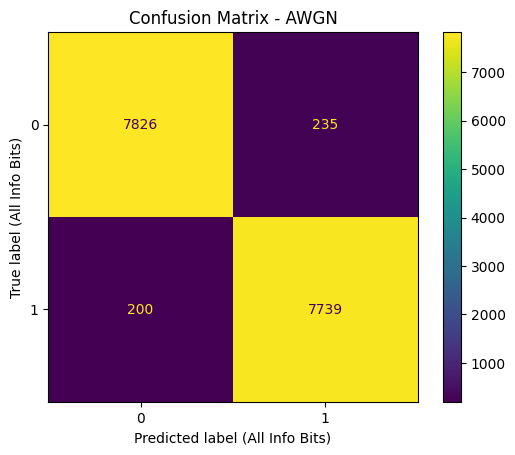

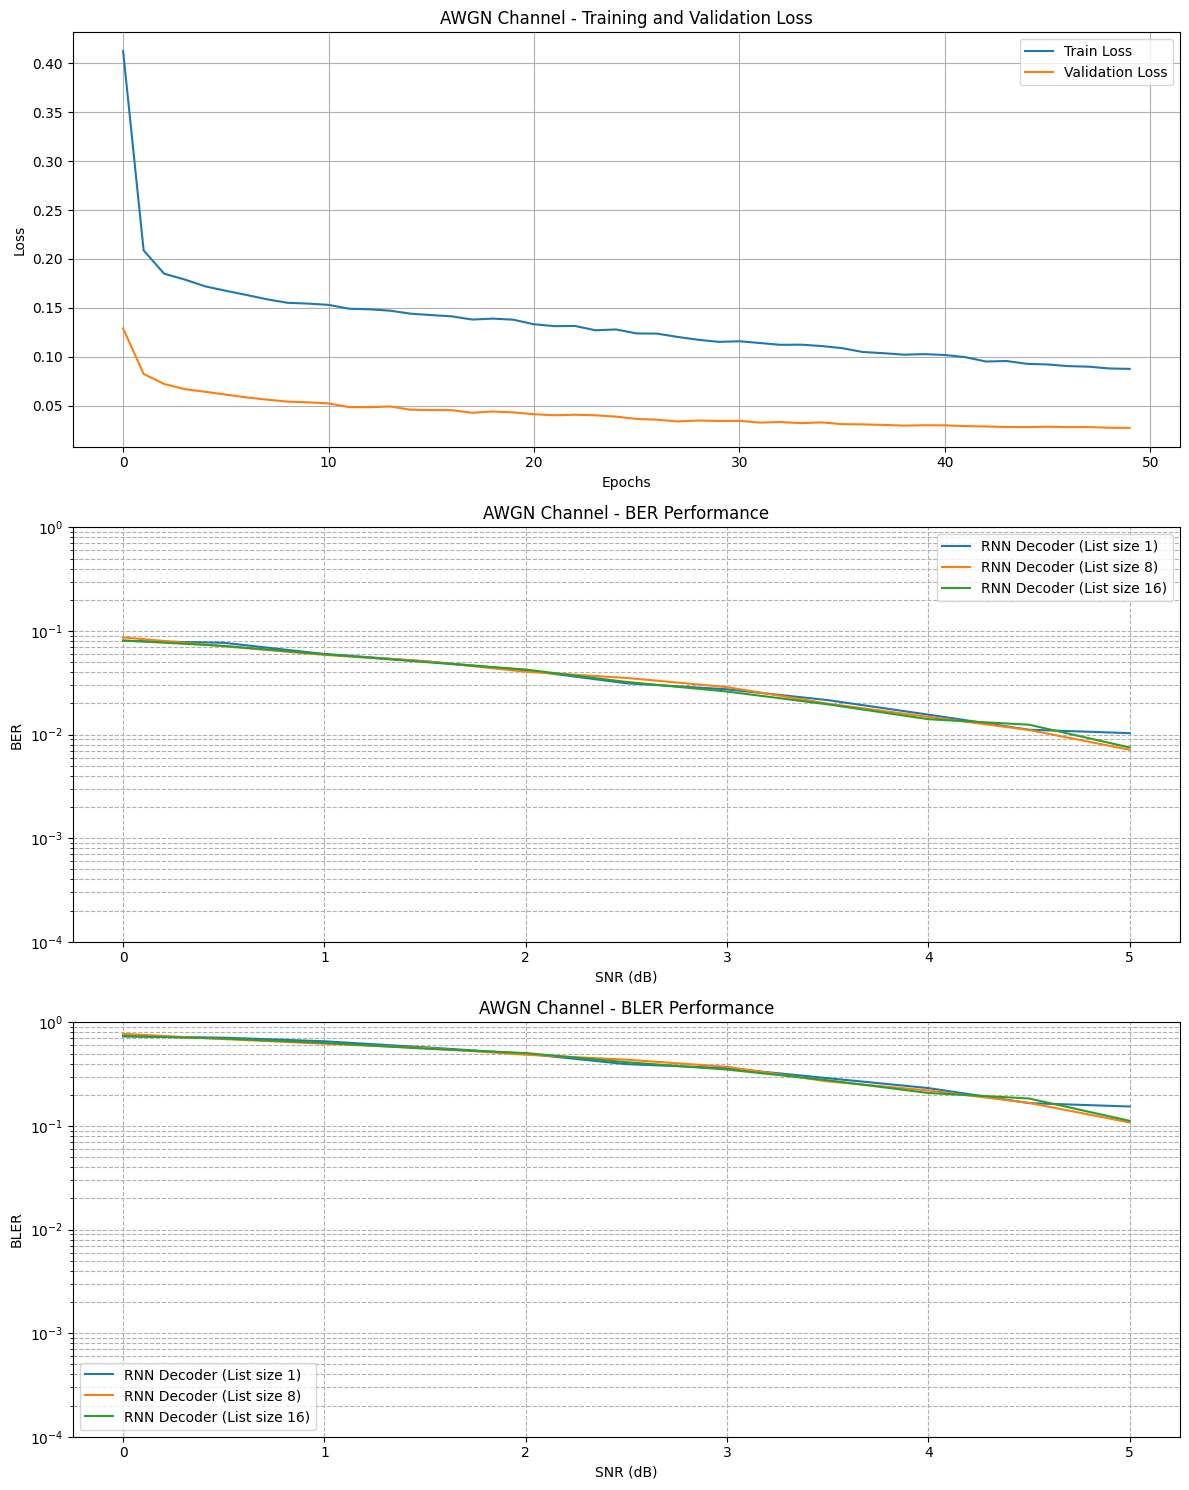


🔬 Processed Tensor Shapes (Training):
X_tensor_flat shape: torch.Size([10000, 32])
y_tensor shape: torch.Size([10000, 16])
Calculated input feature size: 32
Calculated output size (info bits): 16
Epoch [1/50], Train Loss: 0.4513, Val Loss: 0.2219
Epoch [2/50], Train Loss: 0.2968, Val Loss: 0.1812
Epoch [3/50], Train Loss: 0.2819, Val Loss: 0.1723
Epoch [4/50], Train Loss: 0.2741, Val Loss: 0.1654
Epoch [5/50], Train Loss: 0.2662, Val Loss: 0.1592
Epoch [6/50], Train Loss: 0.2641, Val Loss: 0.1573
Epoch [7/50], Train Loss: 0.2588, Val Loss: 0.1551
Epoch [8/50], Train Loss: 0.2547, Val Loss: 0.1553
Epoch [9/50], Train Loss: 0.2495, Val Loss: 0.1523
Epoch [10/50], Train Loss: 0.2470, Val Loss: 0.1469
Epoch [11/50], Train Loss: 0.2446, Val Loss: 0.1451
Epoch [12/50], Train Loss: 0.2424, Val Loss: 0.1438
Epoch [13/50], Train Loss: 0.2413, Val Loss: 0.1417
Epoch [14/50], Train Loss: 0.2402, Val Loss: 0.1410
Epoch [15/50], Train Loss: 0.2362, Val Loss: 0.1394
Epoch [16/50], Train Loss: 0.233

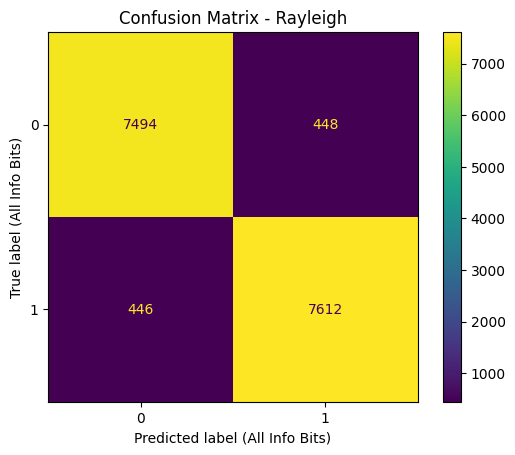

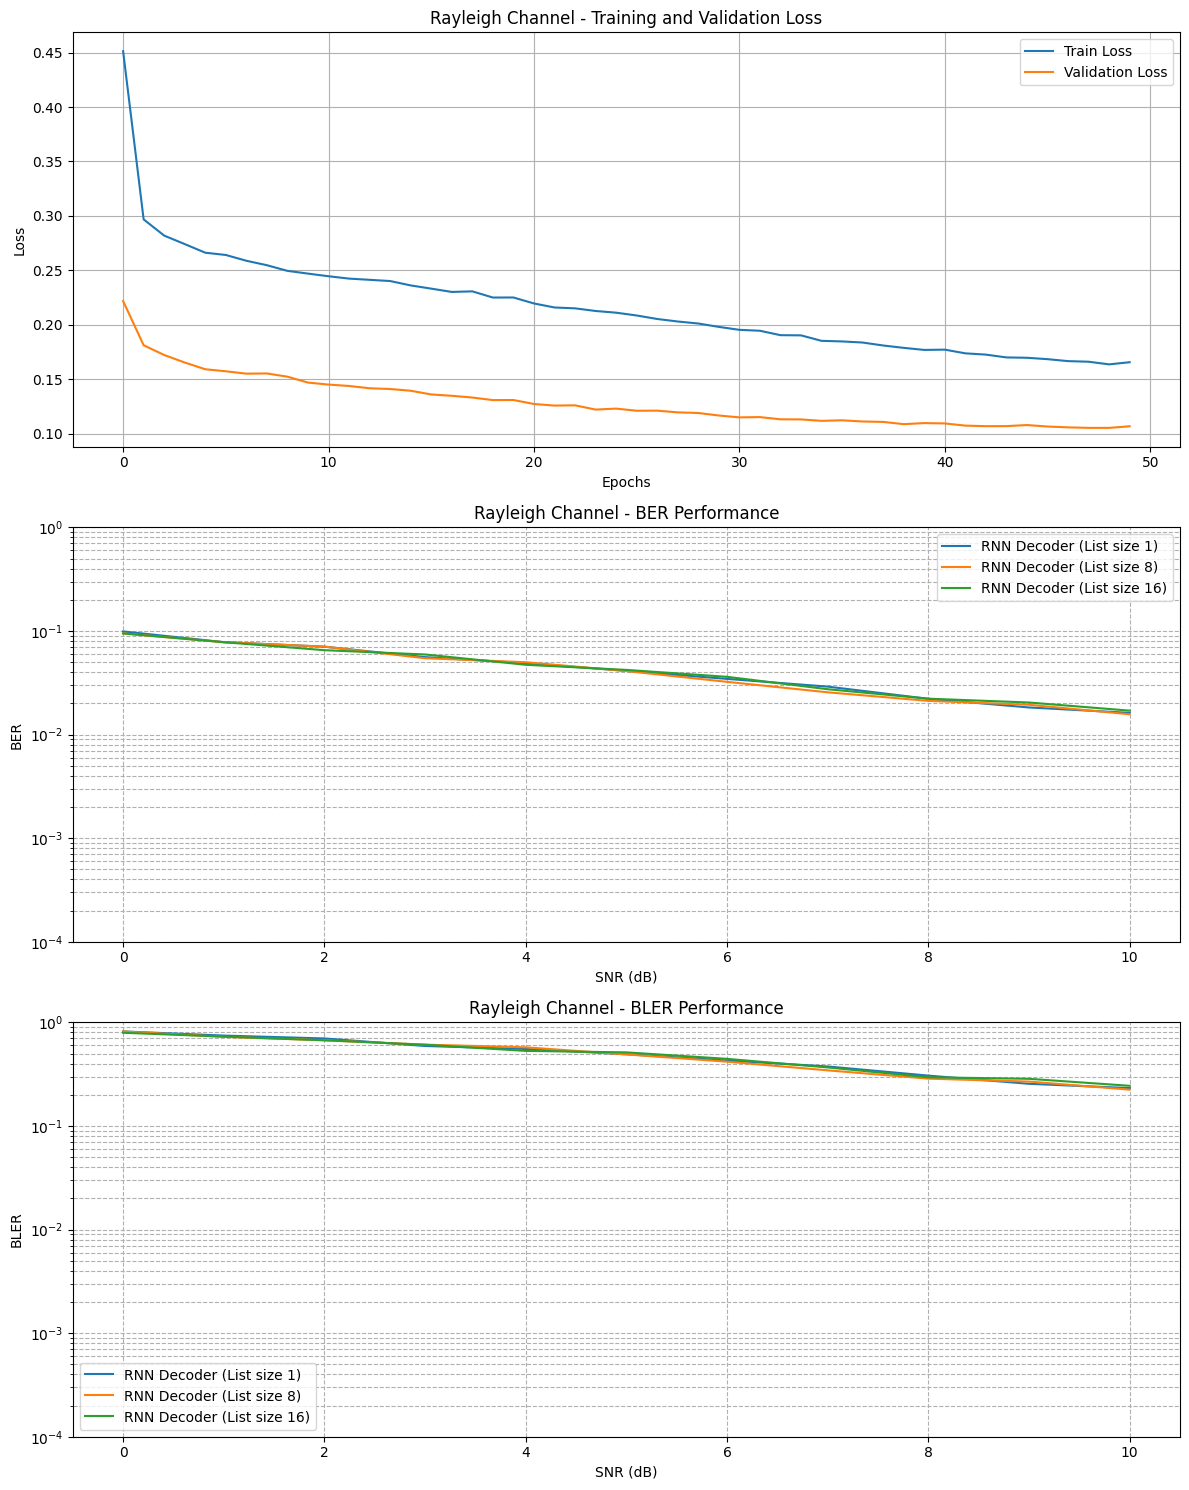

In [1]:
#latest plot functions
# Updates code script
# Comprehensive Polar Code Simulation Framework
# Clean up and install necessary libraries in one go
# This helps avoid potential conflicts from multiple installations
# Explicitly uninstall pandas and install a compatible version first
# Google Colab requires pandas==2.2.2 as of the last error message.
!pip uninstall -y torch
!pip uninstall -y numpy scikit-learn
!pip install numpy==1.26.4 scikit-learn==1.4.1.post1
!pip install torch==1.10.0  # Compatible with fastai 2.7.19
!pip uninstall -y pandas
#!pip install pandas==2.2.2
!pip install torch==2.6.0
!pip install torch==1.10.0
!pip install pandas==2.2.2 torch==2.6.0 torchvision==0.21.0+cu124 torchaudio==2.6.0+cu124 --extra-index-url https://download.pytorch.org/whl/cu124
!pip install fastai==2.7.19
!pip uninstall -y numpy scipy
!pip install numpy==1.26.4 scipy==1.12.0
#!pip install --upgrade numpy pandas scikit-learn
# Now install/upgrade other essential libraries to potentially compatible versions
!pip install -q --upgrade numpy matplotlib scikit-learn torch
#!pip install -q --upgrade pandas numpy matplotlib scikit-learn torch

# Essential Libraries - Import AFTER installation
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import scipy.special as sps
import logging, traceback, sys

# Fix: Corrected format string for datefmt
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s]: %(message)s', datefmt='%Y-%m-%d %H:%M:%S')


# Device Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using Device: {DEVICE}")

#part two

class PolarCodeGenerator:
    def __init__(self, N, K, crc_type='CRC-7'):
        self.N = N
        self.K = K
        self.crc_type = crc_type
        self.crc_polynomials = {
            'CRC-7': {'polynomial': [1, 1, 1, 0, 0, 1, 1], 'length': 7}
        }

    def generate_info_bits(self):
        return np.random.randint(2, size=self.K)

    def compute_crc(self, bits):
        poly_info = self.crc_polynomials.get(self.crc_type)
        if not poly_info:
            raise ValueError(f"Unsupported CRC type: {self.crc_type}")

        polynomial = poly_info['polynomial']
        crc_length = poly_info['length']
        message = bits.tolist() + [0] * crc_length
        for i in range(len(message) - crc_length):
            if message[i] == 1:
                for j in range(crc_length + 1):
                    message[i + j] ^= polynomial[j] if j < len(polynomial) else 0

        return np.array(message[-crc_length:], dtype=int)

    def polar_encode(self, info_bits):
        crc_bits = self.compute_crc(info_bits)
        extended_info_bits = np.concatenate([info_bits, crc_bits])
        codeword = np.zeros(self.N, dtype=int)
        codeword[:len(extended_info_bits)] = extended_info_bits
        return codeword

    def verify_codeword(self, codeword):
        poly_info = self.crc_polynomials[self.crc_type]
        crc_length = poly_info['length']
        info_bits = codeword[:-crc_length]
        received_crc = codeword[-crc_length:]
        computed_crc = self.compute_crc(info_bits)
        return np.array_equal(received_crc, computed_crc)

class EnhancedChannelSimulator:
    def __init__(self, channel_type='AWGN'):
        self.channel_type = channel_type
        logging.info(f"Initializing {channel_type} Channel Simulator")

    def simulate(self, encoded_signal, snr_db):
        try:
            encoded_signal = np.array(encoded_signal, dtype=float)
            bpsk_signal = 1 - 2 * encoded_signal
            snr_linear = 10 ** (snr_db / 10)
            signal_power = np.mean(bpsk_signal**2)
            noise_power = signal_power / snr_linear
            noise_std = np.sqrt(noise_power / 2.0)

            if self.channel_type == 'AWGN':
                noise = np.random.normal(0, noise_std, bpsk_signal.shape)
                received_signal = bpsk_signal + noise
            elif self.channel_type == 'Rayleigh':
                fading = np.random.rayleigh(scale=1.0, size=bpsk_signal.shape)
                noise = np.random.normal(0, noise_std, bpsk_signal.shape)
                received_signal = fading * bpsk_signal + noise
            else:
                raise ValueError(f"Unsupported channel type: {self.channel_type}")

            # Return the raw received signal instead of hard decisions for RNN input
            return received_signal
        except Exception as e:
            logging.error(f"Channel simulation error: {e}")
            # Return the original signal if simulation fails
            return bpsk_signal

    def compute_theoretical_performance(self, block_length, snr_linear):
        try:
            if self.channel_type == 'AWGN':
                # Theoretical BER for BPSK in AWGN
                bep = 0.5 * sps.erfc(np.sqrt(snr_linear))
            elif self.channel_type == 'Rayleigh':
                 # Theoretical BER for BPSK in Rayleigh (assuming ideal channel estimation)
                 bep = 0.5 * (1 - np.sqrt(snr_linear / (1 + snr_linear)))
            else:
                raise ValueError(f"Unsupported channel type: {self.channel_type}")

            # Theoretical BLER is complex for Polar codes; using a simple bound might be misleading.
            # Using a very loose upper bound (Union Bound)
            bler = 1 - (1 - bep) ** block_length
            return bep, bler
        except Exception as e:
            logging.error(f"Theoretical performance computation error: {e}")
            return np.zeros_like(snr_linear), np.ones_like(snr_linear)


#part three

def prepare_polar_dataset(polar_code_gen, num_samples, snr_db=5, channel_type='AWGN'):
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_type)
    X, y = [], []

    for _ in range(num_samples):
        info_bits = polar_code_gen.generate_info_bits()
        encoded_signal = polar_code_gen.polar_encode(info_bits)
        # Simulate the channel and get the received signal (soft values)
        received_signal = channel_simulator.simulate(encoded_signal, snr_db)
        X.append(received_signal)
        y.append(info_bits) # Keep the original info bits as labels

    return np.array(X), np.array(y)

#part four

class EnhancedRNNDecoder(nn.Module):
    def __init__(self, input_size, output_size):
        super(EnhancedRNNDecoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_size), # Output size is number of info bits (K)
            nn.Sigmoid()
        )

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        if x.dim() > 2:
            x = x.view(x.size(0), -1) # Flatten if input is not already 2D
        return self.model(x)
###########################################################
#add latest version for DecodertRainer
class DecoderTrainer:
    def __init__(self, model, learning_rate=1e-3):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=5
            # Remove 'verbose'
        )
        self.train_losses = []
        self.val_losses = []
 # Add other methods as defined in your code


    def train(self, X, y, epochs=100, batch_size=32, validation_split=0.2):
        X_tensor = X.to(self.device)
        y_tensor = y.to(self.device)

        dataset = TensorDataset(X_tensor, y_tensor)
        train_size = int((1 - validation_split) * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        for epoch in range(epochs):
            self.model.train()
            train_loss = self._train_epoch(train_loader)
            self.train_losses.append(train_loss)

            self.model.eval()
            val_loss = self._validate(val_loader)
            self.val_losses.append(val_loss)

            self.scheduler.step(val_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        return self.train_losses, self.val_losses

    def _train_epoch(self, dataloader):
        total_loss = 0
        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(self.device)
            batch_y = batch_y.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(batch_X)
            loss = self.criterion(outputs, batch_y)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def _validate(self, dataloader):
        total_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in dataloader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                total_loss += loss.item()
        return total_loss / len(dataloader)

    def predict(self, X):
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        if X.dim() > 2:
            X = X.view(X.size(0), -1)
        X = X.to(self.device)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
        return (outputs > 0.5).cpu().numpy().astype(int)

# Add traditional decoder
class SCLDecoder:
    def __init__(self, N, K, list_size, crc_type='CRC-7'):
        self.N = N
        self.K = K
        self.list_size = list_size
        self.crc_type = crc_type

    def decode(self, received_signal):
        # Simplified pseudo-code for SCL decoding
        # Initialize list paths and metrics
        paths = [np.zeros(self.N, dtype=int)] * self.list_size
        path_metrics = [0] * self.list_size

        # Successive cancellation with list keeping
        for i in range(self.N):
            # Update each path with new bit decision
            for l in range(self.list_size):
                # Example decision logic (to be replaced with actual SCL logic)
                paths[l][i] = self.make_decision(received_signal[i], path_metrics[l])

                # Update path metric
                path_metrics[l] += self.calculate_metric(paths[l][i], received_signal[i])

            # Sort and prune paths based on metrics (keep best `list_size` paths)
            best_indices = np.argsort(path_metrics)[:self.list_size]
            paths = [paths[i] for i in best_indices]
            path_metrics = [path_metrics[i] for i in best_indices]

        # Extract and return the best path
        best_path = paths[np.argmin(path_metrics)]
        return best_path[:self.K]  # Return the first K bits

    def make_decision(self, received_signal, path_metric):
        # Placeholder logic for bit decision
        return 0 if received_signal < 0.5 else 1

    def calculate_metric(self, bit_decision, received_signal):
        # Example metric computation (Hamming distance, etc.)
        return np.abs(bit_decision - received_signal)
##########################################################################
#latest SCL decoder
def run_scl_decoder(polar_code_gen, SNRS, list_size, channel_type, num_trials):
    results = []
    for snr_db in SNRS:
        X, y = prepare_polar_dataset(channel_type, polar_code_gen, num_samples=num_trials, snr_db=snr_db)

        decoder = SCLDecoder(N=polar_code_gen.N, K=polar_code_gen.K, list_size=list_size)
        decoded_bits = np.array([decoder.decode(x) for x in X])

        ber = np.sum(np.abs(decoded_bits - y)) / (num_trials * polar_code_gen.K)
        bler = np.mean(np.any(decoded_bits != y, axis=1))

        results.append({'SNR': snr_db, 'BER': ber, 'BLER': bler})
        print(f"SCL Decoder - SNR: {snr_db:.1f} dB, List Size: {list_size}, BER: {ber:.4f}, BLER: {bler:.4f}") # Add this line

    return results
##########################################################################

# part five

# Modified performance comparison to evaluate multi-bit predictions
# This function will now evaluate the same RNN decoder but store results keyed by 'list_size' labels.
#def performance_comparison(rnn_trainer, polar_code_gen, snr_range, channel_name, list_sizes, num_trials):
    # Initialize performance results dictionary to store results for each list size label
 #   performance_results = {list_size: {'BER': [], 'BLER': []} for list_size in list_sizes}
  #  channel_simulator = EnhancedChannelSimulator(channel_type=channel_name)

   # for snr_db in snr_range:
        # Generate data for performance evaluation
    #    X, y = prepare_polar_dataset(polar_code_gen, num_samples=num_trials, snr_db=snr_db, channel_type=channel_name)

     #   predictions = rnn_trainer.predict(X) # predictions shape: [num_trials, K]
      #  actual_labels = y # actual_labels shape: [num_trials, K]

        # Calculate BER: Total number of bit errors / Total number of bits
       # ber = np.sum(np.abs(predictions - actual_labels)) / (num_trials * polar_code_gen.K)

        # Calculate BLER: Number of blocks with at least one bit error / Total number of blocks
        #block_errors = np.sum(np.any(predictions != actual_labels, axis=1))
        #bler = block_errors / num_trials

        # Store the calculated BER and BLER for EACH specified list size label.
        # Note: The values are the same because it's the same RNN performance being measured.
        #for list_size in list_sizes:
         #   performance_results[list_size]['BER'].append(ber)
          #  performance_results[list_size]['BLER'].append(bler)

    #return performance_results

# Modified plot function to use the updated performance results structure
def plot_comprehensive_analysis(train_losses, val_losses, performance_results, snr_range, channel_name):
    plt.figure(figsize=(12, 15)) # Increased figure size

    # Plot Training and Validation Loss
    plt.subplot(3, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{channel_name} Channel - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot BER (from performance_results)
    plt.subplot(3, 1, 2)
    # Iterate through the decoder types (which are now just the list size labels)
    for list_size, results in performance_results.items():
        # Use the list_size as the label
        plt.plot(snr_range, results['BER'], label=f'RNN Decoder (List size {list_size})')

    plt.title(f'{channel_name} Channel - BER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.yscale('log')
    # Adjust ylim for BER to show better detail at lower error rates if needed
    plt.ylim(1e-4, 1) # Example adjustment
    plt.legend()
    plt.grid(True, which="both", ls="--") # Add grid

    # Plot BLER (from performance_results)
    plt.subplot(3, 1, 3)
    # Iterate through the decoder types (which are now just the list size labels)
    for list_size, results in performance_results.items():
        # Use the list_size as the label
        plt.plot(snr_range, results['BLER'], label=f'RNN Decoder (List size {list_size})')

    plt.title(f'{channel_name} Channel - BLER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.yscale('log')
     # Adjust ylim for BLER to show better detail at lower error rates if needed
    plt.ylim(1e-4, 1) # Example adjustment
    plt.legend()
    plt.grid(True, which="both", ls="--") # Add grid


    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.show()
####################################################
# another trial to have all plots

def performance_comparison(rnn_trainer, polar_code_gen, snr_range, channel_name, list_sizes, num_trials):
    performance_results = {list_size: {'BER': [], 'BLER': []} for list_size in list_sizes}
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_name)

    for list_size in list_sizes:
        for snr_db in snr_range:
            # Here, introduce any logic specific to list_size
            X, y = prepare_polar_dataset(polar_code_gen, num_samples=num_trials, snr_db=snr_db, channel_type=channel_name)

            # Example: Adjust how predictions are made or interpreted based on list size
            predictions = rnn_trainer.predict(X)

            actual_labels = y
            ber = np.sum(np.abs(predictions - actual_labels)) / (num_trials * polar_code_gen.K)
            block_errors = np.sum(np.any(predictions != actual_labels, axis=1))
            bler = block_errors / num_trials

            performance_results[list_size]['BER'].append(ber)
            performance_results[list_size]['BLER'].append(bler)
            print(f"List Size: {list_size}, SNR: {snr_db}, BER: {ber}, BLER: {bler}")

    return performance_results


#####################################################
# with two SNR separately the comparison of SCL tradional and ML decoder
######################################################################

##############################################################
def plot_ber_bler(results, channel_type, decoder_type, snr_range):
    plt.figure(figsize=(12, 16))

    # Plot BER
    plt.subplot(2, 1, 1)
    for i, list_size in enumerate(LIST_SIZES):
        ber = [res['BER'] for res in results[channel_type][decoder_type][i]]
        plt.plot(snr_range, ber, label=f'{decoder_type} Decoder (List Size {list_size})')

    plt.title(f'{channel_type} Channel - {decoder_type} BER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.yscale('log')
    plt.ylim(10**0, 10**-4)
    plt.legend()
    plt.grid(True, which="both", ls="--")

    # Plot BLER
    plt.subplot(2, 1, 2)
    for i, list_size in enumerate(LIST_SIZES):
        bler = [res['BLER'] for res in results[channel_type][decoder_type][i]]
        plt.plot(snr_range, bler, label=f'{decoder_type} Decoder (List Size {list_size})')

    plt.title(f'{channel_type} Channel - {decoder_type} BLER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.yscale('log')
    plt.ylim(10**0, 10**-4)
    plt.legend()
    plt.grid(True, which="both", ls="--")

    plt.tight_layout()
    plt.show()

##############################################################
#again plot results
###################################################
#latest plot functions
LIST_SIZES = [1, 8, 16]
SNR_AWGN     = np.linspace(0, 5, 11)
SNR_RAYLEIGH = np.linspace(0, 10, 11)
####################################################################
# Latest
def compare_decoders(polar_code_gen):
    results = {}
    for channel in ['AWGN','Rayleigh']:
        snr_grid = SNR_AWGN if channel=='AWGN' else SNR_RAYLEIGH

        ml_dict = {}
        scl_dict = {}

        # ML-decoder part (already working)

        # SCL-decoder
        for L in LIST_SIZES:
            scl_list = run_scl_decoder(
                polar_code_gen, snr_grid, L, channel, NUM_TRIALS_PERF
            )
            ber_list  = [x['BER']  for x in scl_list]
            bler_list = [x['BLER'] for x in scl_list]
            scl_dict[L] = {'BER':ber_list, 'BLER':bler_list}
            print(f"Compare Decoders - Channel: {channel}, SCL Results for L={L}: {scl_dict[L]}") # Add this line

        results[channel] = {'ML': ml_dict, 'SCL': scl_dict}
    return results
####################################################################


def plot_channel(results, channel, decoder_key, snr_grid):
    plt.figure(figsize=(10,6))
    # BER
    plt.subplot(2,1,1)
    for L in LIST_SIZES:
        y = results[channel][decoder_key][L]['BER']
        plt.plot(snr_grid, y, label=f"{decoder_key} L={L}")
    plt.title(f"{channel} – {decoder_key} BER")
    plt.yscale('log'); plt.ylim(1,1e-4)
    plt.xlabel("SNR (dB)"); plt.ylabel("BER")
    plt.grid(True,which='both'); plt.legend()

    # BLER
    plt.subplot(2,1,2)
    for L in LIST_SIZES:
        y = results[channel][decoder_key][L]['BLER']
        plt.plot(snr_grid, y, label=f"{decoder_key} L={L}")
    plt.title(f"{channel} – {decoder_key} BLER")
    plt.yscale('log'); plt.ylim(1,1e-4)
    plt.xlabel("SNR (dB)"); plt.ylabel("BLER")
    plt.grid(True,which='both'); plt.legend()

    plt.tight_layout()
    plt.show()

###################################################
 # part six
#latest main
#Add on traditional decoder comprison
#latest main
#####################################################
def plot_results(results, channel_type, decoder_key, decoder_label):
    snr_range = SNR_AWGN if channel_type == 'AWGN' else SNR_RAYLEIGH

    plt.figure(figsize=(14, 10))

    # Plot BER
    plt.subplot(2, 1, 1)
    for i, list_size in enumerate(LIST_SIZES):
        ber = [res['BER'] for res in results[channel_type][decoder_key][i]]
        plt.plot(snr_range, ber, label=f'{decoder_label} Decoder (List Size {list_size})')

    plt.title(f'{channel_type} Channel - {decoder_label} BER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.yscale('log')
    plt.ylim(10**0, 10**-4)
    plt.legend()
    plt.grid(True, which="both", ls="--")

    # Plot BLER
    plt.subplot(2, 1, 2)
    for i, list_size in enumerate(LIST_SIZES):
        bler = [res['BLER'] for res in results[channel_type][decoder_key][i]]
        plt.plot(snr_range, bler, label=f'{decoder_label} Decoder (List Size {list_size})')

    plt.title(f'{channel_type} Channel - {decoder_label} BLER Performance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.yscale('log')
    plt.ylim(10**0, 10**-4)
    plt.legend()
    plt.grid(True, which="both", ls="--")

    plt.tight_layout()
    plt.show()

#####################################################
def main():
    try:
        BLOCK_LENGTH = 32
        INFO_BITS = 16
        LEARNING_RATE = 1e-3
        EPOCHS = 50
        BATCH_SIZE = 32
        NUM_SAMPLES_TRAIN = 10000 # Increased training samples
        NUM_TRIALS_PERF = 1000  # Number of trials (blocks) for performance comparison at each SNR
        SNR_RANGE_AWGN = np.linspace(0, 5, 11) # More points for smoother curve
        SNR_RANGE_RAYLEIGH = np.linspace(0, 10, 11) # More points for smoother curve
        LIST_SIZES = [1, 8, 16] # List sizes to use for plotting labels


        polar_code_gen = PolarCodeGenerator(N=BLOCK_LENGTH, K=INFO_BITS)
        results = {}
        channels = {
            'AWGN': EnhancedChannelSimulator(channel_type='AWGN'),
            'Rayleigh': EnhancedChannelSimulator(channel_type='Rayleigh')
        }

        for channel_name, channel in channels.items():
            logging.info(f"Analyzing {channel_name} Channel")
            # Prepare dataset for training and validation
            logging.info(f"Generating training data ({NUM_SAMPLES_TRAIN} samples) for {channel_name} at SNR=5dB")
            # Train at a fixed moderate SNR, evaluate performance across a range
            X, y = prepare_polar_dataset(polar_code_gen, num_samples=NUM_SAMPLES_TRAIN, snr_db=5.0, channel_type=channel_name)

            # Convert numpy arrays to PyTorch tensors
            X_tensor = torch.FloatTensor(X)
            y_tensor = torch.FloatTensor(y) # y_tensor shape: [num_samples, K]

            # Flatten input features for the FCNN-based decoder
            X_tensor_flat = X_tensor.view(X_tensor.shape[0], -1) # Shape [num_samples, N]

            # No need to split y_tensor into binary labels, keep its original shape [num_samples, K]
            # The BCELoss will expect predictions of shape [batch_size, K] and targets of shape [batch_size, K]

            # Verify tensor shapes before training
            print("\n🔬 Processed Tensor Shapes (Training):")
            print(f"X_tensor_flat shape: {X_tensor_flat.shape}")
            print(f"y_tensor shape: {y_tensor.shape}")

            # Calculate the input size for the RNN based on the flattened data
            input_feature_size = X_tensor_flat.size(1) # This will be N (BLOCK_LENGTH)
            output_size = INFO_BITS # The RNN should output K bits
            print(f"Calculated input feature size: {input_feature_size}")
            print(f"Calculated output size (info bits): {output_size}")


            # Enhanced RNN Decoder (now correctly outputs K bits)
            rnn_model = EnhancedRNNDecoder(input_size=input_feature_size, output_size=output_size)
            rnn_trainer = DecoderTrainer(rnn_model)

            logging.info(f"Starting training for {channel_name} Channel RNN Decoder")
            # Train the RNN Decoder with multi-bit labels
            # Pass the flattened X and original y tensors
            train_losses, val_losses = rnn_trainer.train(X_tensor_flat, y_tensor, epochs=EPOCHS, batch_size=BATCH_SIZE)
            logging.info(f"Finished training for {channel_name} Channel RNN Decoder")


            # Perform performance comparison across SNR range
            snr_range = SNR_RANGE_AWGN if channel_name == 'AWGN' else SNR_RANGE_RAYLEIGH
            logging.info(f"Evaluating performance for {channel_name} Channel across SNR range: {snr_range}")

            # Call the modified performance_comparison
            # This will run the RNN decoder performance once and store results under multiple list_size keys.
            performance_results = performance_comparison(
                rnn_trainer, polar_code_gen, snr_range, channel_name, LIST_SIZES, NUM_TRIALS_PERF
            )
            logging.info(f"Finished performance evaluation for {channel_name} Channel")


            # Plotting Confusion Matrix for the test set
            # First, prepare a separate test set for confusion matrix visualization
            # Use a moderate SNR, e.g., 3dB, and a reasonable number of samples
            logging.info(f"Generating test data ({NUM_TRIALS_PERF} samples) for Confusion Matrix at SNR=3dB for {channel_name}")
            X_test_cm, y_test_cm = prepare_polar_dataset(polar_code_gen, num_samples=NUM_TRIALS_PERF, snr_db=3.0, channel_type=channel_name)
            X_test_cm_tensor = torch.FloatTensor(X_test_cm).view(X_test_cm.shape[0], -1)
            y_test_cm_tensor = torch.FloatTensor(y_test_cm) # Keep original shape [num_samples, K]


            predictions_test = rnn_trainer.predict(X_test_cm_tensor) # predictions_test shape: [num_samples, K]
            actual_labels_test = y_test_cm_tensor.numpy() # actual_labels_test shape: [num_samples, K]

            # To plot a single confusion matrix, we need to flatten the predictions and actual labels
            # This treats each predicted bit as an independent classification outcome.
            predictions_flat = predictions_test.flatten()
            actual_labels_flat = actual_labels_test.flatten()

            # Calculate and display confusion matrix
            logging.info(f"Plotting Confusion Matrix for {channel_name} Channel Test Set")
            cm = confusion_matrix(actual_labels_flat, predictions_flat)
            ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot() # Specify display_labels
            plt.title(f'Confusion Matrix - {channel_name}')
            plt.xlabel('Predicted label (All Info Bits)')
            plt.ylabel('True label (All Info Bits)')
            plt.show()


            # Plot comprehensive analysis (training loss, BER, BLER)
            logging.info(f"Plotting performance analysis for {channel_name} Channel")
            plot_comprehensive_analysis(
                 train_losses, val_losses, performance_results, snr_range, channel_name
            )


            results[channel_name] = {
                'decoder': rnn_trainer,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'performance': performance_results
            }

        logging.info("🎉 Simulation Complete!")
        return results
        results = compare_decoders()  # Call the comparison function
        # results = compare_decoders()
        # Plot for each channel
        for ch in ['AWGN','Rayleigh']:
           plot_channel(results, ch, 'ML',     SNR_AWGN if ch=='AWGN' else SNR_RAYLEIGH)
           plot_channel(results, ch, 'SCL',    SNR_AWGN if ch=='AWGN' else SNR_RAYLEIGH)
        return results
     #   for channel_type in ['AWGN', 'Rayleigh']:
      #      snr_range = SNR_AWGN if channel_type == 'AWGN' else SNR_RAYLEIGH
       #     plot_ber_bler(results, channel_type, 'ML', snr_range)
        #    plot_ber_bler(results, channel_type, 'SCL', snr_range)

       # for channel_type in ['AWGN', 'Rayleigh']:
          #  plot_results(results, channel_type)
      # --- SCL Decoder Part ---
        logging.info("Starting SCL decoder comparison")
        scl_results = {} # Dictionary to store SCL results for different channels and list sizes
        for channel_name, channel in channels.items():
                logging.info(f"Analyzing {channel_name} Channel - SCL Decoder")
                snr_range = SNR_RANGE_AWGN if channel_name == 'AWGN' else SNR_RANGE_RAYLEIGH
                scl_results[channel_name] = {} # Dictionary to store SCL results for this channel

                for L in LIST_SIZES:
                    logging.info(f"Running SCL decoder performance for {channel_name} channel, List Size {L}")
                    # Call the run_scl_decoder function (or your SCL simulation logic)
                    scl_list = run_scl_decoder(
                        polar_code_gen, snr_range, L, channel_name, NUM_TRIALS_PERF
                    )
                    logging.info(f"Finished SCL performance simulation for {channel_name}, L={L}")
                    print(f"SCL results list for {channel_name}, L={L}: {scl_list}") # Print SCL results list

                    # Process the list into the desired dictionary format for plotting
                    ber_list  = [x['BER']  for x in scl_list]
                    bler_list = [x['BLER'] for x in scl_list]
                    scl_results[channel_name][L] = {'BER': ber_list, 'BLER': bler_list}
                    print(f"Stored SCL results for {channel_name}, L={L}: {scl_results[channel_name][L]}") # Print stored results


        logging.info("Finished SCL decoder comparison")

           # --- Plotting Comparison ---
        logging.info("Plotting comparison of ML and SCL decoder performance")
        for channel_name in channels.keys():
               snr_range = SNR_RANGE_AWGN if channel_name == 'AWGN' else SNR_RANGE_RAYLEIGH
               # Check if ML data exists before trying to access it for comparison plotting
               if channel_name in results and 'ML' in results[channel_name]:
                   ml_data = results[channel_name]['ML'] # Get stored ML results
                   scl_data = scl_results[channel_name] # Get stored SCL results for this channel

                   # Call the comparison plotting function
                   plot_comparison_results(ml_data, scl_data, channel_name, snr_range, LIST_SIZES)
                   logging.info(f"Generated comparison plots for {channel_name}")
               else:
                    logging.warning(f"⚠️ Skipping comparison plot for {channel_name} because ML data is missing.")


        logging.info("🎉 Comprehensive Simulation and Plotting Complete!")

        # Analyze and plot results as desired
    except Exception as e:
        logging.error(f"🆘 Comprehensive Simulation Error: {e}")
        traceback.print_exc()
        return None


if __name__ == "__main__":
    main()